# Introduction 

The goal of this demonstration is to show how to use the wrapped Boundary Element Method (BEM) solver to simulate angular-dependent wave reflections from a meshed surface geometry. The BEM solver computes the reflected sound field based on the surface mesh, assuming perfectly rigid (non-absorbing) boundaries.

By simulating both a structured sample and a flat reference surface, we obtain directional reflection data that can be used to compute scattering-related quantities, such as the scattering coefficient[^1]. In this demonstration, we focus on setting up the simulation and aggregating the results into standardized SOFA files, which can then be used for further analysis and postprocessing outside this notebook.

> **Note**: This demonstration uses `NumCalc`, an open-source Boundary Element Method (BEM) solver[^2]. The solver does not simulate absorption or energy loss within the material. It assumes rigid boundaries and computes only the directional redistribution of reflected energy due to geometry.
>
> The `NumCalc` backend originates from the [Mesh2HRTF](https://www.spatialaudio.net/mesh2hrtf/) project, where it is implemented in C++ and exposed via a Python extension module. The `mesh2scattering` package wraps this solver to simulate directional reflection from arbitrary geometries and manage input/output in the SOFA format.

This notebook walks through the following steps:

1. Load the sample and reference geometry  
2. Define source and receiver positions  
3. Create the BEM simulation project  
4. Run the simulation (already precomputed for this demo)  
5. Postprocess the results and generate SOFA files  
6. (Optional) Use the results to compute and visualize the scattering coefficient


[^1]: Vorländer, M., & Mommertz, E. (2000). *Definition and measurement of random-incidence scattering coefficients*. Applied Acoustics, 60(2), 187–199. https://doi.org/10.1016/S0003-682X(99)00056-0

[^2]: Kreuzer, W., Pollack, K., Brinkmann, F., & Majdak, P. (2024). *NumCalc: An open-source BEM code for solving acoustic scattering problems*. Engineering Analysis with Boundary Elements, 161, 157–178. https://doi.org/10.1016/j.enganabound.2024.01.008

# Installation

We assume that you are aware of basic Python concepts including the use of ``conda`` and ``pip``. If you did not install pyfar already please do so or install it together with the mesh2scattering package by running the command

``pip install mesh2scattering``


# Demo

### Import
let's import some basic packages... trimesh is used to visualize and process data from triangular meshes. For this Demo we will ignore any warnings.

In [9]:
import mesh2scattering as m2s
import pyfar as pf
import os
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import warnings
warnings.filterwarnings("ignore")


### Create the Project
We need to set the paths for the meshes. Please notice that the sample should lay on the x-y-plane where z is the height. 
Addtionally we need to set the project path, where we will aggregate all information for this demo
todo: rename project to "demoproject"?

In [10]:
# set paths
sample_path = os.path.join('meshes', 'sine_n10_1', 'sample.stl')
reference_path = os.path.join('meshes', 'reference_n10_1', 'sample.stl')
project_path = os.path.join(os.getcwd(), 'project')
if not os.path.isdir(project_path):
    os.mkdir(project_path)

## Optionally comment out these lines to inspect the geometries
# sample_mesh = trimesh.load(sample_path)
# sample_mesh.show()
# reference_mesh = trimesh.load(reference_path)
# reference_mesh.show()

Now we need to set the parameters of the sample. 

Furthermore we need to define the symmetry properties of the sample. In our case we have a sine-shaped surface, so the sample is symmetrical to the x-axis and y-axis, therefore we set the ``symmetry_azimuth`` to 90 and 180 degree. A rotational symmetry is not give, so we set it to ``False``.

In [11]:
structural_wavelength = 0.177/2.5
sample_diameter = 0.8
model_scale = 2.5
sample_baseplate_hight = 0.01


symmetry_azimuth = [90, 180]
symmetry_rotational = False

Lets collect all the metadata of the sample and the surface into the related class object.
The meta data will not influence the simulation or postprocessing, they are just collected and exported in the sofa file at the end.

In [ ]:
sine_description = m2s.input.SurfaceDescription(
    structural_wavelength_x=.177/2.5,
    structural_wavelength_y=0,
    structural_depth=.051/2.5,
    surface_type=m2s.input.SurfaceType.PERIODIC,
    symmetry_azimuth=symmetry_azimuth,
    symmetry_rotational=symmetry_rotational,
)
mesh_sine = m2s.input.SampleMesh(
    mesh=sample_mesh,
    surface_description=sine_description,
    sample_baseplate_hight=0.01,
    sample_diameter=sample_diameter,
    sample_shape=m2s.input.SampleShape.ROUND,
)
reference_description = m2s.input.SurfaceDescription(
    structural_wavelength_x=0,
    structural_wavelength_y=0,
    structural_depth=0,
    surface_type=m2s.input.SurfaceType.FLAT,
    symmetry_azimuth=[],
    symmetry_rotational=True,
)
mesh_reference = m2s.input.SampleMesh(
    mesh=trimesh.load(reference_path),
    surface_description=reference_description,
    sample_baseplate_hight=0.01,
    sample_diameter=sample_diameter,
    sample_shape=m2s.input.SampleShape.ROUND,
)

Define the frequency array. For simplicity and computation cost we just use 4 frequencies. 
If you want to create 3rd- or 1st octave band frequencies have a look on ``pyfar.dsp.filter.fractional_octave_frequencies``.
#todo simulate more frequencies per octave and average over octaves, to get more reliable results.

In [12]:
frequencies = np.array([1000, 2000, 3000, 4000])

### Source and Receiver Positions
Now we need to define the source and receiver positions. Therefore we create a sampling grid based on gaussian quadrature. We only use the upper hemisphere for the receiver positions. We use a radius of 50m, to make sure that we are in the far field.

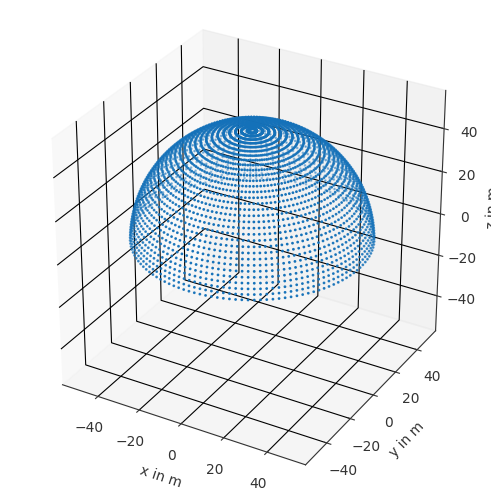

In [13]:
receiver_radius = 50

receiverPoints = pf.samplings.sph_gaussian(
    sh_order=63, radius=receiver_radius)
receiverPoints.weights = pf.samplings.calculate_sph_voronoi_weights(
    receiverPoints)
receiverPoints = receiverPoints[receiverPoints.colatitude < np.pi/2]
receiverPoints.show()

plt.show()


The receiver positions can now go into its related class. The class requires faces, but they can be simply calcualted by the class by using ``from_spherical``.

In [14]:
evaluation_grid = m2s.input.EvaluationGrid.from_spherical(
    receiverPoints, 'grid')

Same for the source positions. The radius is set to 10 according to the diffusion ISO Standard 17497-2.
#todo computational costs

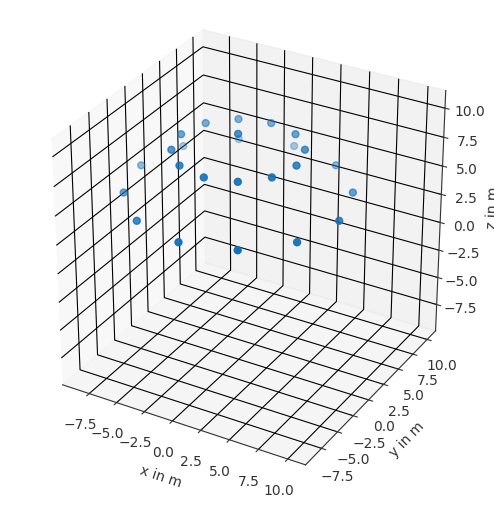

In [15]:
source_delta_deg = 30
source_radius = 10
sourcePoints = pf.samplings.sph_equal_angle(
    source_delta_deg, source_radius)
sourcePoints = sourcePoints[sourcePoints.colatitude < np.pi/2]
sourcePoints.weights = np.cos(sourcePoints.elevation)
sourcePoints.show()
plt.show()

This symmetry settings are required for the postprocessing and and we can speed up our simulating by skipping incident angles and calculate them in the postprocessing by mirroring the existing data. Therefore we can skip the azimuth angles grater than 90 degree for the source positions.

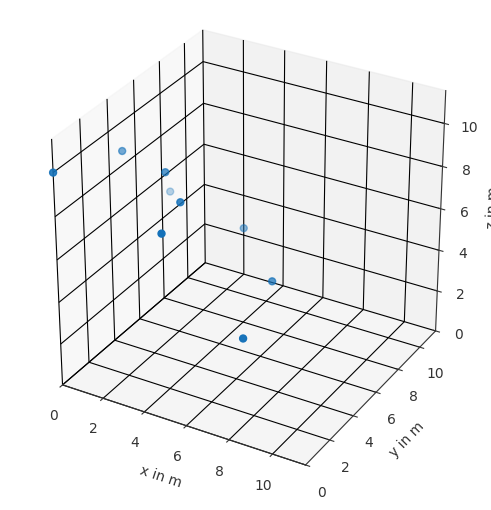

In [10]:
sourcePoints_reduced = sourcePoints[sourcePoints.azimuth <= np.pi/2]
sourcePoints_reduced.show()
plt.show()

Now we can add put the source positions into the correct class formate. We will define Plane waves.

In [11]:
sourcePoints_reduced.cartesian *= -1
sound_sources = m2s.input.SoundSource(
    source_coordinates=sourcePoints_reduced,
    source_type=m2s.input.SoundSourceType.PLANE_WAVE,
)

let's plot the scene

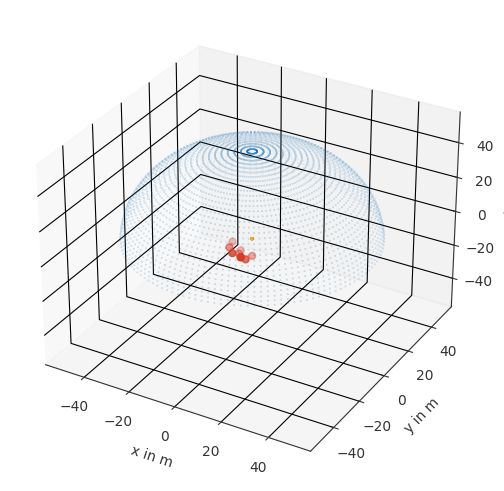

In [12]:
sample = trimesh.load_mesh(sample_path).vertices
sample_coords = pf.Coordinates(sample[:, 0],sample[:, 1],sample[:, 2])
ax = pf.plot.scatter(receiverPoints, s=1/20)
pf.plot.scatter(sourcePoints_reduced, ax=ax)
pf.plot.scatter(sample_coords, ax=ax, s=1/72)
plt.show()


Now we can create the project. Please notice that the project was already created and simulated for demo.

In [13]:
m2s.input.write_scattering_project_numcalc(
    project_path=os.path.join(project_path, 'sine'),
    project_title='sine',
    frequencies=frequencies,
    sound_sources=sound_sources,
    evaluation_grids=[evaluation_grid],
    sample_mesh=mesh_sine,
    )
m2s.input.write_scattering_project_numcalc(
    project_path=os.path.join(project_path, 'reference'),
    project_title='reference',
    frequencies=frequencies,
    sound_sources=sound_sources,
    evaluation_grids=[evaluation_grid],
    sample_mesh=mesh_reference,
    )

## run project
To execute the project you need to build the ``NumCalc`` project. If you use Windows, the exe can be directly downloaded and on mac or linux it can be build, see the function documentation for more information.

In [14]:
numcalc_path = m2s.numcalc.build_or_fetch_numcalc()

Now we can run the simulation, this may take some time. This example is already simulated so we don't need to wait. If we don't explicitly define then ``numcalc_path`` it will use ``m2s.numcalc.build_or_fetch_numcalc()`` in the background to determine the numcalc_path.

In [15]:
m2s.numcalc.manage_numcalc(
    os.path.join(os.getcwd(), project_path), wait_time=1)


Starting manage_numcalc with the following arguments [Jul 30 2025, 14:57:56]
----------------------------------------------------------------------------
project_path: /home/redrr/Mesh2scattering/examples/project
numcalc_path: /home/redrr/miniconda3/envs/pyfar310/lib/python3.10/site-packages/mesh2scattering/numcalc/bin/NumCalc
max_ram_load: 31.01 GB (31.01 GB detected, 21.19 GB available)
ram_safety_factor: 1.05
max_cpu_load: 90 %
max_instances: 16 (16 cores detected)
wait_time: 1 seconds
starting_order: alternate
confirm_errors: False


Per project summary of instances that will be run
-------------------------------------------------
Detected 2 NumCalc projects in
/home/redrr/Mesh2scattering/examples/project


'reference' is already complete
'sine' is already complete


... waiting for the last NumCalc instances to finish (checking every second, Jul 30 2025, 14:57:56)

All NumCalc projects finished at Jul 30 2025, 14:57:56


## Post processing
Now we need to create the scattering pattern sofa files out of the simulation results. Here the symmetry is also applied. since the reference sample is always rotational symmetric, the data for the missing angles are rotated in this was sample and reference  data will have the same dimensions and coordinate

In [16]:
m2s.output.write_pressure(os.path.join(project_path, 'sine'))
m2s.output.write_pressure(os.path.join(project_path, 'reference'))


 Writing the project report ...

 Writing the project report ...


calculate the scattering coefficient for each incident angle and the random one from the scattering pattern

In [17]:
m2s.process.calculate_scattering(
    os.path.join(project_path, 'sine_grid.pressure.sofa'),
    os.path.join(project_path, 'reference_grid.pressure.sofa'),
    'sine',
    )

SOFA file contained custom entries
----------------------------------
OriginalFrequencies, RealScaleFrequencies, Lbyl, SampleStructuralWavelength, SampleStructuralWavelengthX, SampleStructuralWavelengthY, SampleModelScale, SampleDiameter, SpeedOfSound, DensityOfMedium, ReceiverWeights, SourceWeights, SampleSymmetryAzimuth, SampleSymmetryRotational
SOFA file contained custom entries
----------------------------------
OriginalFrequencies, RealScaleFrequencies, Lbyl, SampleStructuralWavelength, SampleStructuralWavelengthX, SampleStructuralWavelengthY, SampleModelScale, SampleDiameter, SpeedOfSound, DensityOfMedium, ReceiverWeights, SourceWeights, SampleSymmetryAzimuth, SampleSymmetryRotational


## Read and plot data
example of plotting the scattering coefficient

SOFA file contained custom entries
----------------------------------
OriginalFrequencies, RealScaleFrequencies, Lbyl, SampleStructuralWavelength, SampleStructuralWavelengthX, SampleStructuralWavelengthY, SampleModelScale, SampleDiameter, SpeedOfSound, DensityOfMedium, ReceiverWeights, SourceWeights, SampleSymmetryAzimuth, SampleSymmetryRotational


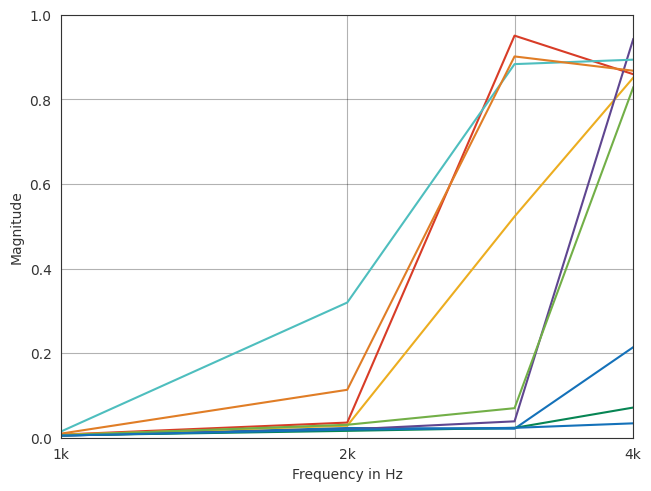

In [18]:
s_rand_path = os.path.join(
    project_path, 'sine.scattering.sofa')

s_rand, _, _ = pf.io.read_sofa(s_rand_path)
ax = pf.plot.freq(s_rand, dB=False)
ax.set_ylim(0,1)
plt.show()